## This code creates the initial surface 
The initial configuration of the modeling domain resembles the topography of a natural source-to-sink system with 3400 m elevation in the headwaters, a length of 4500 km, a downstream decreasing fluvial channel slope, and successive inflections in gradient associated with transitions from the coastal-plain to continental shelf and from the shelf to slope.

In [1]:
import numpy as np
import pandas as pd
import math
from matplotlib import cm
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.ndimage.filters as filters
from scipy.interpolate import RectBivariateSpline
from scipy.ndimage.filters import gaussian_filter

In [2]:
xdata = np.array([0, 25e4, 50e4, 100e4, 150e4, 250e4, 300e4, 350e4, 450e4]) # longitudinal distance
ydata = np.array([2500,3000/2, 2000/2, 100/2, 0, -500, -3e3, -3e3, -3e3])#elevation
nx = 450 #number of nodes in modeling domain x axis
ny = 200#number of nodes in modeling domain y axis
xp = np.linspace(0, 4500000, nx+1)  # dx = 10km resolution
yp = np.linspace(0, 2000000, ny+1)  # dy = 10km resolution
p3 = np.poly1d(np.polyfit(xdata, ydata, 4))
p30 = np.poly1d(np.polyfit(xdata, ydata, 30))
pass

/usr/local/lib/python3.5/dist-packages/numpy/lib/polynomial.py:629: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:3326: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0, 'Distance (m)')

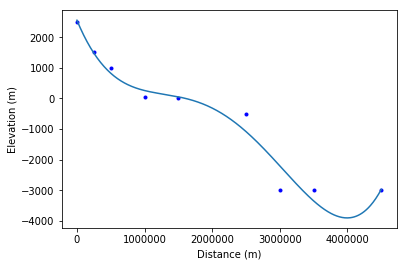

In [3]:
plt.plot(xdata, ydata, 'b.', xp, p3(xp), '-')
plt.ylabel('Elevation (m)')
plt.xlabel('Distance (m)')

Text(0.5, 0, 'Distance (m)')

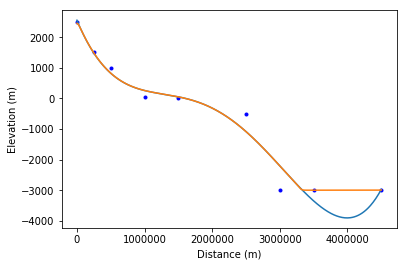

In [8]:
#Some modifications: change the bathymetry of the ocean floor (the right edge)
a = np.ones(120)* -3e3
elev = p3(xp)
for i in range(330,450):
    elev[i] = a[i-330]
    
#Smooth the curve
elev_gs = filters.gaussian_filter1d(elev,sigma=3)
# ef is a factor by which elevation can be adjusted up or down so that the shoreline and thus base level can be moved
ef=5e2
elevation=elev_gs+ef

#Plot the longitudinal profile 
plt.plot(xdata, ydata, 'b.', xp, p3(xp), '-')
plt.plot(xp, elev_gs, label='final')
plt.ylabel('Elevation (m)')
plt.xlabel('Distance (m)')

In [5]:
#This checks at which index of the dataset the elevation is zero to "split" the domain in marine or terrestrial 
id = np.where(elev_gs<-ef)[0]
print (id[0])


215


## Extending the longitudinal profile in the third dimension and imposing a longitudinal topographic low in the middle of the model
To ensure that our simulated drainage basin produces a point- source for sediment input to the marine domain we imposed a longitudinal topographic low in the middle of the model.
The surface is exported in the format required by BADLANDS

In [6]:
f = open("../2_model_running/data/Delta_initialsurface.csv", "w")
h0 = 500.#this controls the slope inland
h1 = 50
hbot = -100# stepper gradient marine
a = -2.*h0/(ny-1)
a1 = -5.*h1/(ny-1)
for j in range(0,ny):
    if j<int(ny/2):
        h = a*j+h0
    if j>int(ny/2):
        h = -a*j-h0
    for i in range(0,nx):
        if i >= id[0]:
            if j<int(ny/2):
                aa = 2.*(hbot - h1)/(ny-1)
                bb = h1
                h = aa*j+bb
            if j>int(ny/2):
                aa = 2.*(h1-hbot)/(ny-1)
                bb = h1 - aa*(ny-1)
                h = aa*j+bb
        f.write( str(xp[i]) + " " + str(yp[j]) + " " + str(elev_gs[i]+h+ef) + "\n"  )#"\t"
f.close()     

## Checking that the cross-section of the initial surface makes sense 

Text(0.5, 0, 'Distance (m)')

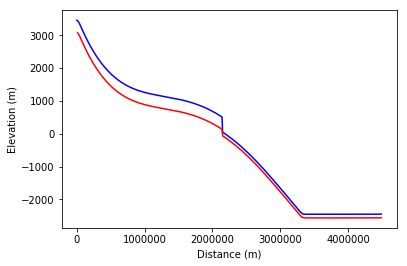

In [9]:
XS=pd.read_csv('../2_model_running/data/Delta_initialsurface.csv', sep=' ', header=None)

#X-section on the edge of the modeling domain
plt.plot(XS[0][0:450], XS[2][0:450], 'blue')
#X-section on the middle of the modeling domain
plt.plot(XS[0][(450*125)+1:(450*126)], XS[2][(450*125)+1:(450*126)], 'red')
plt.ylabel('Elevation (m)')
plt.xlabel('Distance (m)')